# Pipline de dados

 - Pipline de ingestão de dados, ETL e apresentação ao usuário final (profissional de dados), utilizando multiplas tecnologias.

### **Resumo do projeto**

Inicialmente, far-se-á a configuração do BotFather, do Telegram, que nos auxiliará na implantação do webhook. Conforme arquitetura representa abaixo, o webhook enviará a mensagem ao API Gateway (condigurado no ambiente AWS), que, por sua vez, dará início à função Lambda responsável por ingerir, pré-processar e armazenar os dados em formato .json.

Portanto, nosso sistema reagirá à eventos ocorridos no grupo em que o bot do Telegram estiver instalado (*event-driven*), e, faremos a ingestão de dados toda vez que um evento ocorrer (ingestão via *streaming*).

Na segunda etapada, a de ETL, processaremos blocos de dados, com frequência diária (*processamento via batch*). A fonte de dados será o bucket S3 que armazena os dados ingeridos e persistidos em sua forma crua; e o destino será um bucket S3 que armazenará os dados, agora enriquecidos, para consumo dos profissionais de dados.

Por fim, faremos uma rápida exploração dos dados, a fim de validar e percebener insights que possam ajudar a equipe responsável pelo atendimento e vendas.

### **Sobre o conjunto de dados**

Para fins didáticos, os dados aqui utilizados são fictícios. Trata-se de um sistema que ainda não foi colocado em produção. Portanto, os dados não são válidos para embasar qualquer decisão.

Contudo, ressalta-se, um modelo colado em produção seguiria a mesma arquitetura utilizada neste trabalho.

### Arquitetura

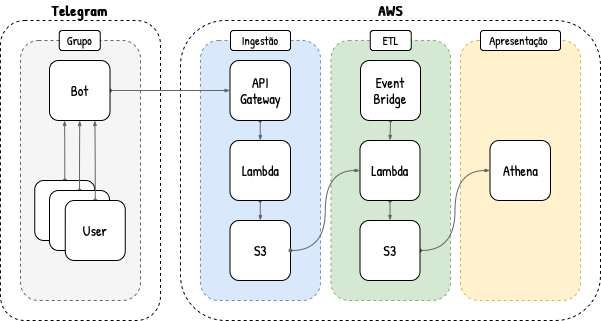

## 1. Ingestão

* Telegram

As mensagens enviadas ao grupo em que o bot está instalado, são capturadas via API. A configuração do bot é realizada no próprio telegram, que fornece o token de acesso, que será integrada à API que receberá as mensagens.

> **Nota**: a configuração do bot pode ser realizada com a documentação, encontrada neste [link](https://core.telegram.org/bots/api)

Após a configuração do bot, instanciaremos o teoken e a url base, que será usada para acesso das rotas disponibilizadas pelo BotFather.

In [ ]:
# instanciando token

from getpass import getpass

token = getpass()


··········


In [ ]:
# Instanciando url base

base_url = f'http://api.telegram.org/bot{token}'

Conforme documentação, você pode usar a rota `getUpdates` para acessar as mensagens recebidas, e ter uma ideia inicial de sua estrutura.

In [ ]:
# Visualizando mensagens recebidas
import requests
import json

response = requests.get(f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent = 2))

{
  "ok": true,
  "result": [
    {
      "update_id": 331699701,
      "message": {
        "message_id": 30,
        "from": {
          "id": 6098589445,
          "is_bot": false,
          "first_name": "Fagner",
          "language_code": "pt-br"
        },
        "chat": {
          "id": 6098589445,
          "first_name": "Fagner",
          "type": "private"
        },
        "date": 1680524833,
        "text": "Testando configura\u00e7\u00e3o do bot"
      }
    }
  ]
}


Neste momento, estamos com o bot instalado no grupo de interesse, no Telegram.

Para finalizar o processo de configuração do webhook do telegram, precisaremos entrar na etapa de ingestão de dados, e configurar os demais serviços. Isto porque, precisaremos da url da API que vai receber os dados das mensagens do telegram.

O link que conectará o bot à API de armazenamento nos ajudará a armazenar os dados assim que forem recebidos, e no formato mais próximo possível do original. Nossa ingestão seguirá o conceito de ingestão via `streaming`, portanto.

* S3

Nesta etapa, criaremos um bucket no AWS S3, que funcionará passivamente, armazenando as mensagens capturadas pelo bot do telegram.

bucket criado: `telegram-datalake-raw`

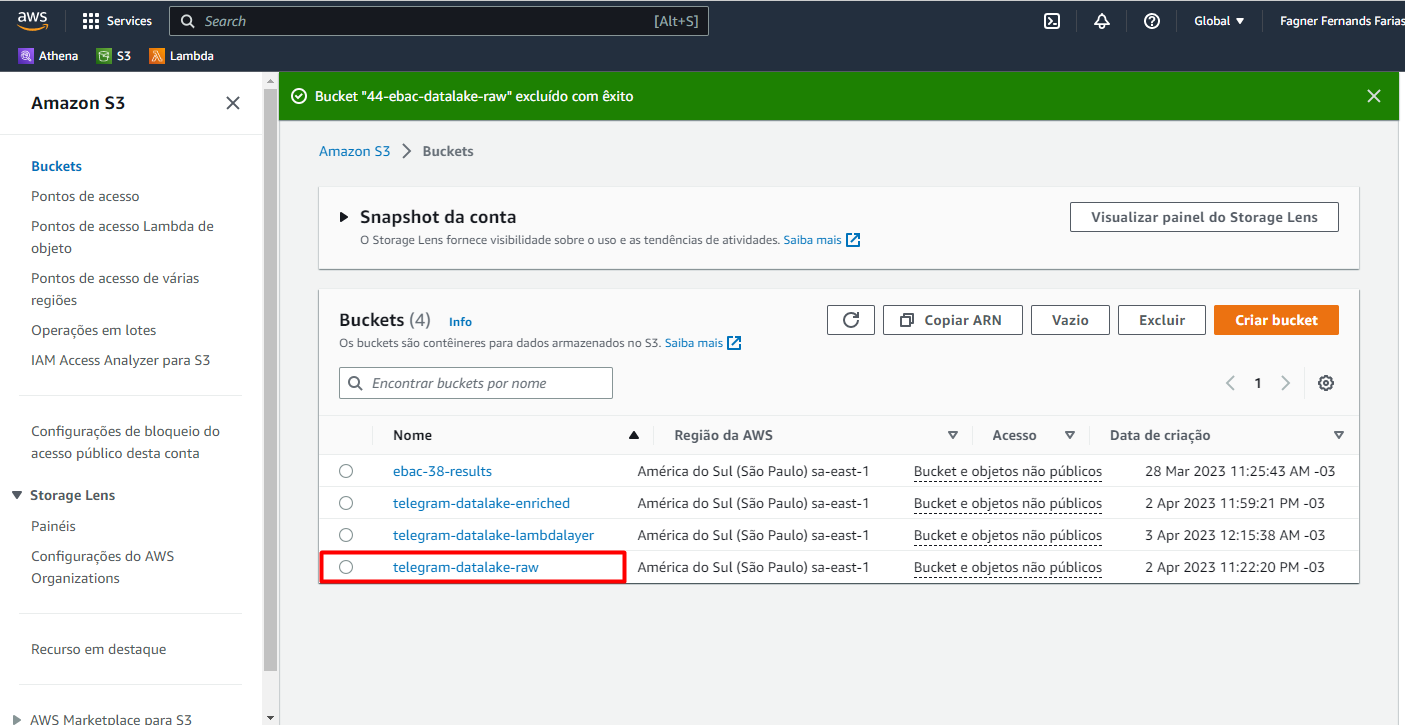

* Lambda

Precisaremos realizar o pré-processamento das mensagens capturadas pelo bot telegram, antes de persistí-los no bucket criado.

Para isso, criaremos uma função lambda, realizaremos todas as permissões necessárias, e, devemos instanciar as variáveis de ambiente.

Por fim, esclareça-se que, preparamos os dados para serem armazenados de forma particionada.

In [ ]:
# Instalando modulo externo para acessar serviços AWS

!pip install -q boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 9.8 MB/s eta 0:00:00


In [ ]:
# criando função lambda

import os
import json
import logging
from datetime import datetime, timezone, timedelta

import boto3

def lambda_handler(event: dict, context: dict) -> dict:

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')
  
  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")


Função lambda criada: `telegram-datalake-raw`

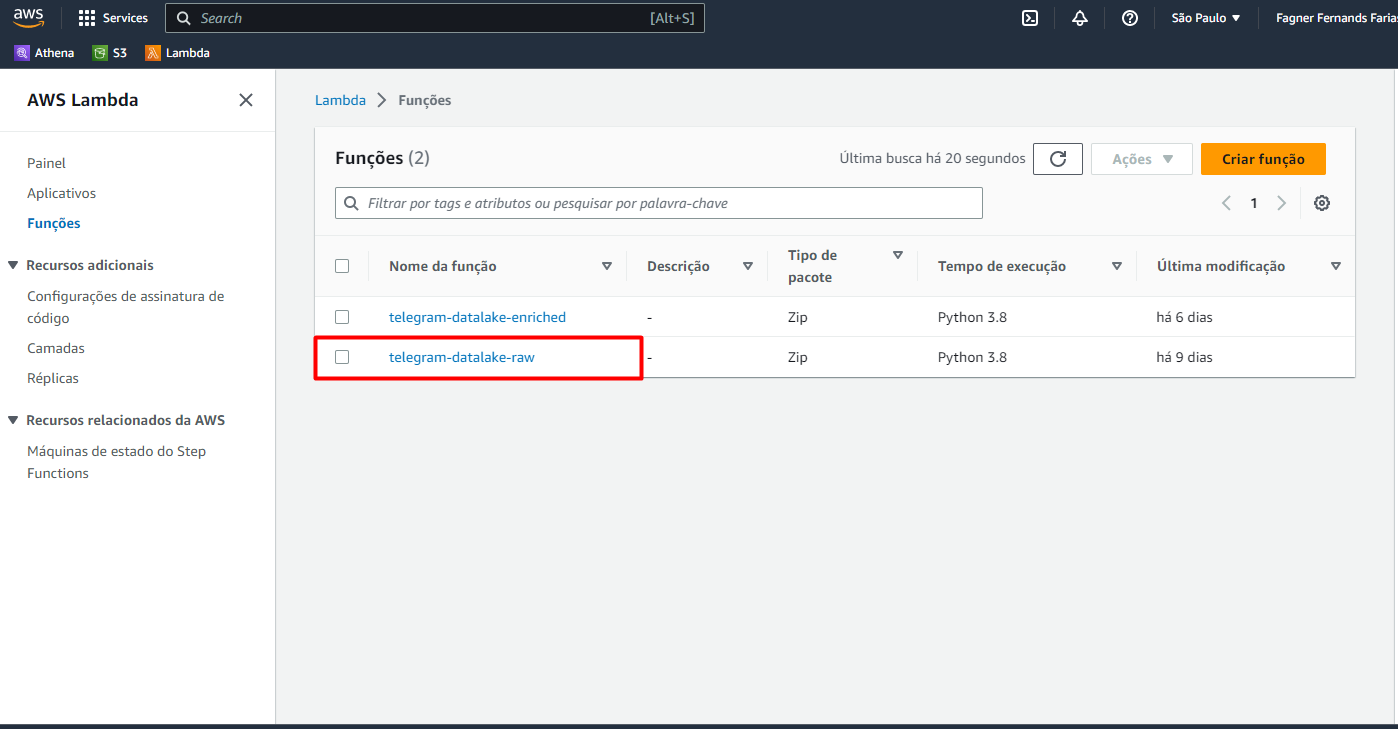

* API Gateway (AWS)

Ainda na etapa de ingestão, configuraremos uma API (API REST) para receber as mensagens enviadas pelo webhook, e iniciar a função `lambda` criada.

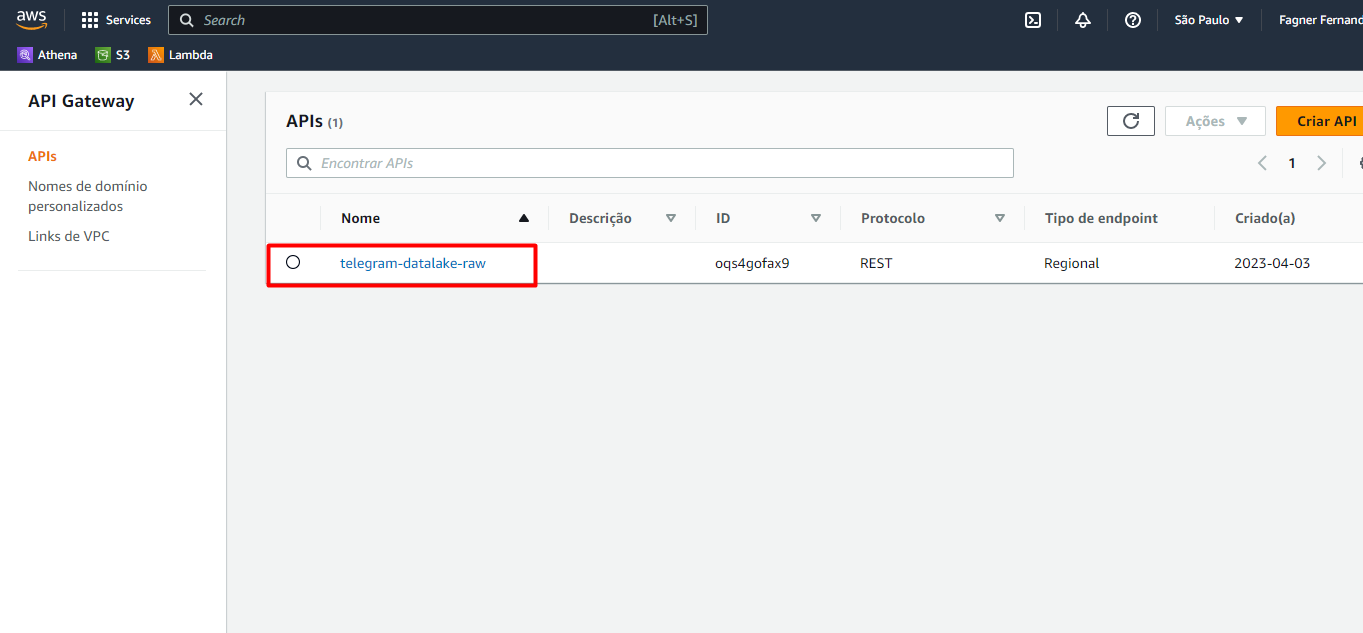

**url gerada pela api**: `https://oqs4gofax9.execute-api.sa-east-1.amazonaws.com/dev`

Vamos instanciar esta url em uma variável, pois a utilizaremos para configurar o webhook telegram.



In [ ]:
# Instanciando url da API

aws_api_gateway_url = 'https://oqs4gofax9.execute-api.sa-east-1.amazonaws.com/dev'

In [ ]:
# Configurando webhook telegram

response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent = 2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


Vamos visualizar algumas informações sobre o webhook.

In [ ]:
# Visualizando informações

response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://oqs4gofax9.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 0,
    "max_connections": 40,
    "ip_address": "54.233.233.228"
  }
}


Com isto, finalizamos a etapa de ingestão de dados. Todas as mensagens enviadas ao grupo serão armazenadas no bucket criado, em formato .json para posterior tratamento e análise.

Veja as figuras a seguir.

Bucket antes de receber uma mensagem:

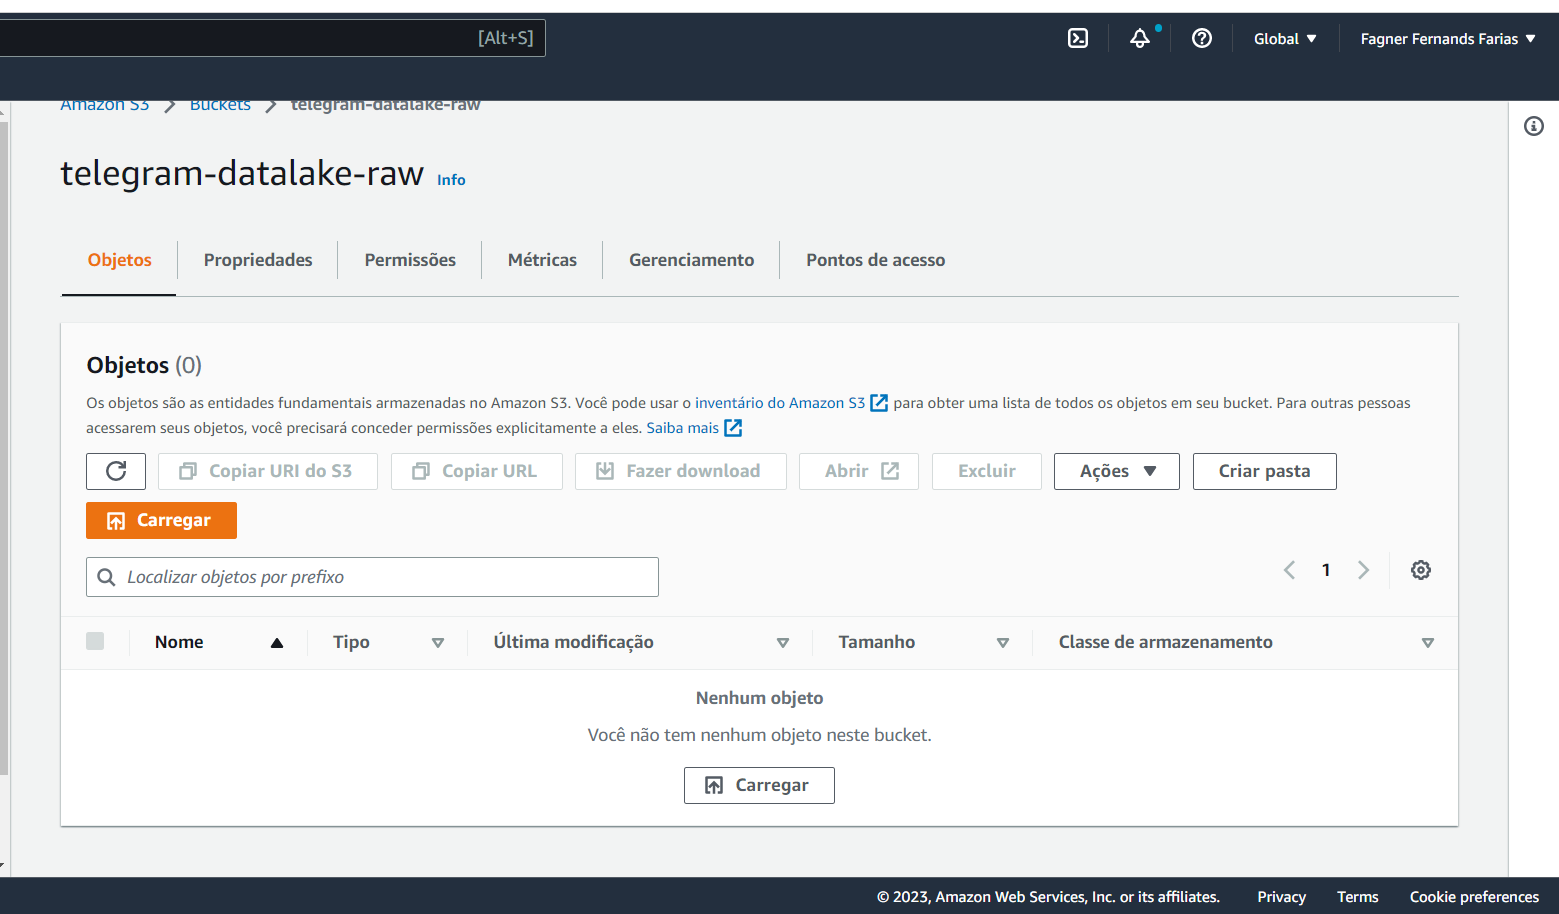

Bucket após o envio de uma mensagem teste, devidamente configurado para partição por dia:

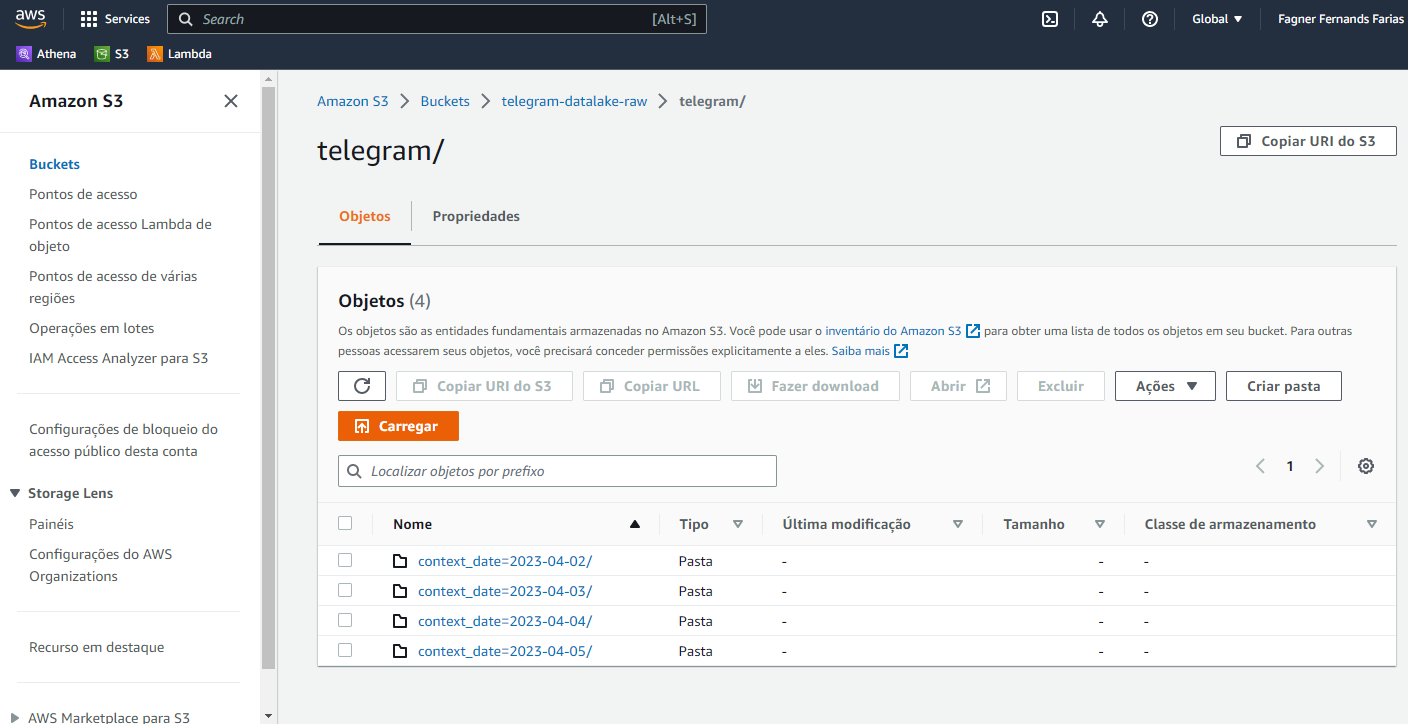

Vamos para etapa de ETL.

## 2. ETL

Extração, trasnformação e carregamento. Nesta etapa há a manipulação dos dados ingeridos do sistema trasacional. Há uma infinidade de formas de se realizar o processos desta etapa, e variam de acordo com o objetivo do projeto, e as características dos dados; contudo, em geral, os dados carregados em sua forma crua são:
 * extraídos
 * higienizados
 * duplicados
 * particionados
 * comprimidos
 * persistidos


Tudo isso, para posterior consumo dos profissionais de dados.

* AWS S3

Após os processos de extração e transformação, presistemos os dados em um novo bucket. Este procedimento permite que os dados originais estejam sempre disponíveis para re-análise.

bucket criado: telegram-datalake-enriched
 

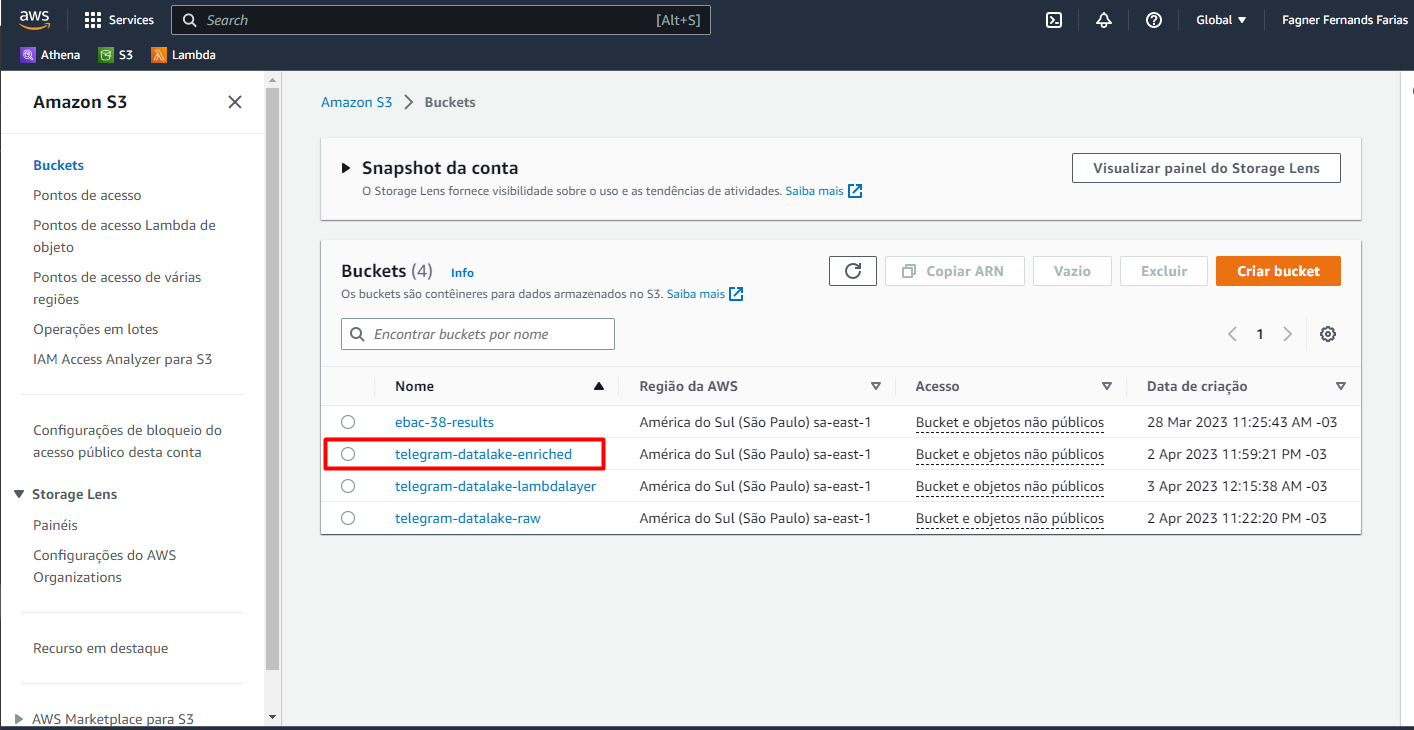

* Lambda

Na etapa de ETL a função lambda que criaremos agirá de forma ativa, processando os dados persistidos na camada crua (do dia anterior), e, após, persistindo-os no bucket designado para armazenanto da camada enriquecida.

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None
          
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False

Função para Data-Wrangling

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Função lambda criada: `telegram-datalake-enriched`

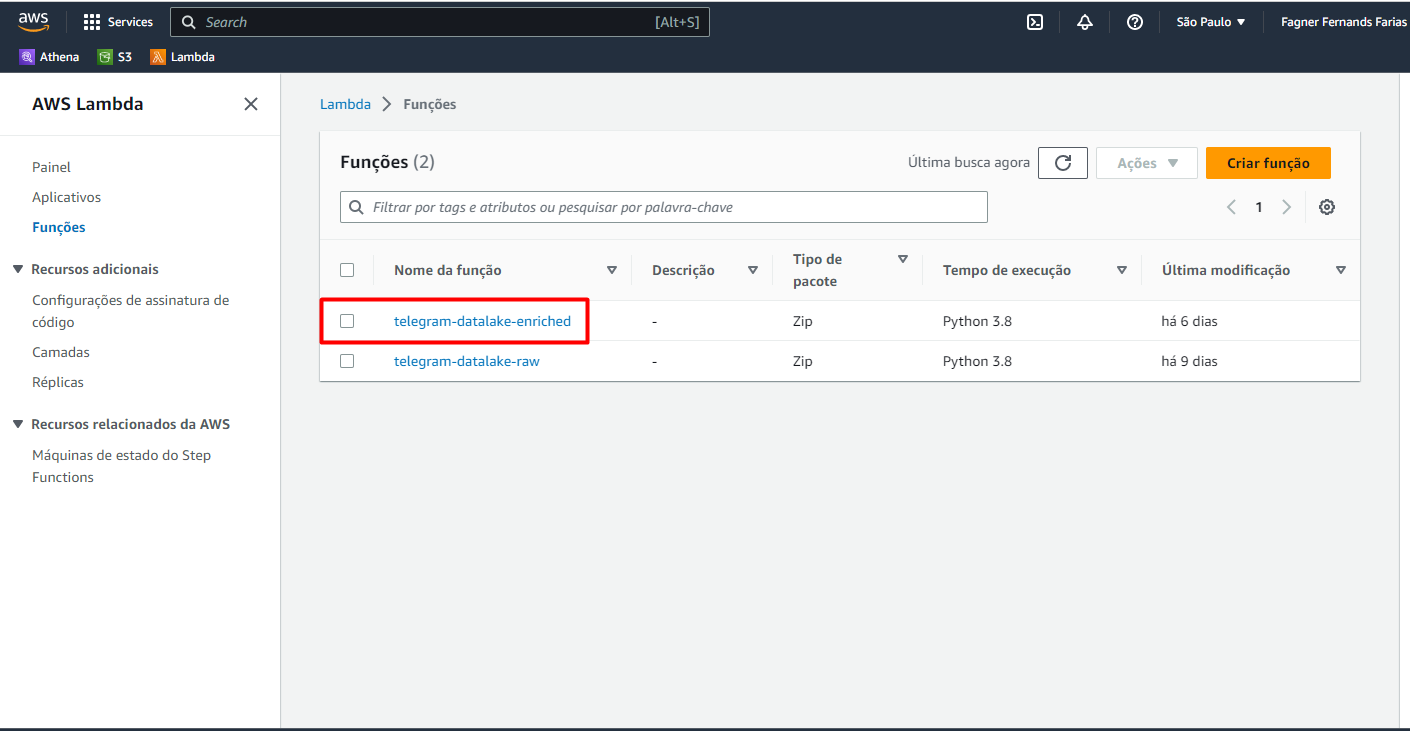

* Event Bridge

o AWS Event Bridge tem a função de ativar, diaramente, o processo de ETL que acabamos de criar.

Desta forma, devemos fazer a configuração de uma regra que ativará, em um determinado horário, a  função lambda `telegram-datalake-enriched`, uma vez por dia.

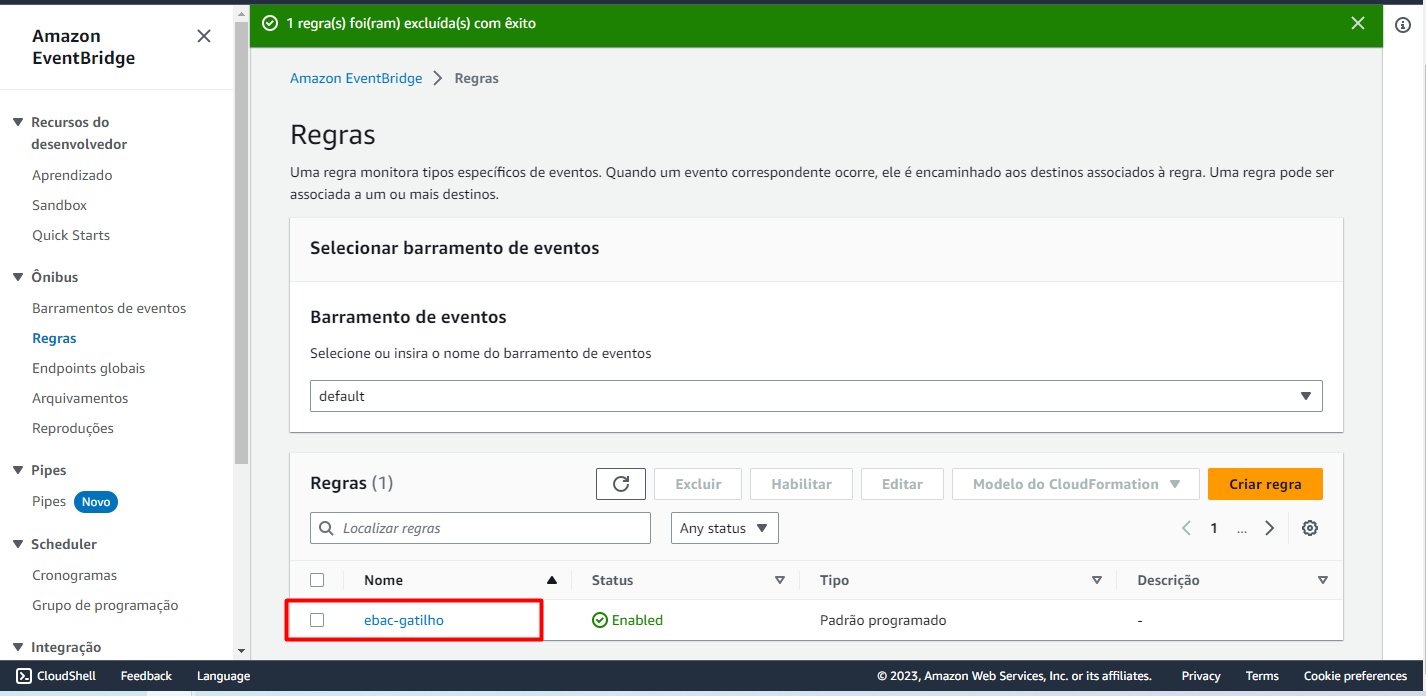

Uma vez finalizada a etapa de ELT, os dados estão prontos para serem apresentados aos usuários dos sistemas analíticos.

Depois de realizar o trabalho de ingestão dos dados, e ETL, agora, pode-se realizar sumarização, agragação e outros tarefas analíticas sobre os dados, a fim de validar ou descobrir insigths.

E, é o que será feito na próxima etapa.

## 3. Apresentação

Nesta etapa, usaremos o engine de consultas SQL da AWS (AWS Athena) para criar tabelas e realizar consultas aos dados.

Criando tabela no Athena



```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint, 
  `user_id` bigint, 
  `user_is_bot` boolean, 
  `user_first_name` string, 
  `chat_id` bigint, 
  `chat_type` string, 
  `text` string, 
  `date` bigint)
PARTITIONED BY ( 
  `context_date` date)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://telegram-datalake-enriched/telegram'

```



Adicionando partições disponíveis:



```sql
MSCK REPAIR TABLE telegram;
```



Os dados estão prontos para análise!

* Analytics

Visualizando as 10 primeiras linhas



```sql
select * from telegram limit 10;

```



 Visualizando a quantidade de mensagens por dia.



```sql
SELECT 
  context_date, 
  count(1) AS "message_amount" 
FROM "telegram" 
GROUP BY context_date 
ORDER BY context_date DESC

```



Visualizando a quantidade de mensagens por usuário, por dia.



```sql
SELECT 
  user_id, 
  user_first_name, 
  context_date, 
  count(1) AS "message_amount" 
FROM "telegram" 
GROUP BY 
  user_id, 
  user_first_name, 
  context_date 
ORDER BY context_date DESC
```



Media do tamanho das mensagens, por usuário, por dia.



```sql
SELECT 
  user_id, 
  user_first_name, 
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length" 
FROM "telegram" 
GROUP BY 
  user_id, 
  user_first_name, 
  context_date 
ORDER BY context_date DESC
```




Quantidade de mensagens por hora por dia da semana por número da semana.


```sql
WITH 
parsed_date_cte AS (
    SELECT 
        *, 
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram" 
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount" 
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```



## 3. Conclusão.

A construção de um pipline dados permitiu:

1 - A utilização comercial das mensagens, e metadados das mensagens. Com essas informações em mãos será possível validar insights das equipes responsáveis pelo marketing, vendas, custumer success, etc.

2 - Para implantar a arquitetura inicialmente apresentada, foram utilizadas várias tecnologias, dentre as quais:
  
  * BotFhater - nativo do Telegram;
  * Python - para configuração do webhook, escrever as funções lambda, e, pré-visualizar o formato em que o webook do Telegram envia as mensagens;
  * Vários sistemas da AWS:

      - S3
      - Lambda
      - Athena
      - EventBridge
      - API Gateway
      - IAM.

3 - Em algumas horas, utilizando recursos de cloud computing, você ou sua empresa já podem dispor de um dos recursos mais valiosos atualmente, os dados.